# Calculation of similarity curves - prediction of developmental stages

This notebook demonstrates the use of Twin Network for calculation of similarity curves. This means, similarities between one test image and images from a reference image time series are assessed. Calculation of similarities with a reference image series can be used to predict the corresponding developmental stage of the test image.

# Table of Contents
* [General](#first-bullet)
* [Load paths](#second-bullet)
* [Load model](#third-bullet)
* [Calculate embeddings](#fourth-bullet)
* [Calculate similarities](#fifth-bullet)
* [(Optional) Save similarities](#sixth-bullet)
* [Plot similarities as similarity curve](#seventh-bullet)
* [Plot similarities as developmental trajectory](#eigth-bullet)
* [Compare similarities of embryos at different acquisition timepoints](#ninth-bullet)

## General <a class="anchor" id="first-bullet"></a>

General imports and class definitions

In [1]:
%load_ext autoreload
%autoreload 2

Load paths from config file

In [2]:
from twinnet_tools.tnconfig import ProjectConfig

config = ProjectConfig("twinnet_config")

ProjectConfig: /home/hmorales/WorkSpace/Development/TwinNetwork/CodeGitHub/TwinNet-main/code/Scripts/twinnet_config/Linux/config.json


In [3]:
dir_root_data = config.json["dir_data"]
dir_root_scripts = config.json["dir_scripts"]
paths_anchor = config.json["paths_json_reference_src_imgs_1"]
path_model_zebrafish = config.json["dir_model_zebrafish_original"]

config_paths_script = config.json["Similarities_developmental_stages"]
path_src_data_test = config_paths_script["dir_data_src"]
path_dst = config_paths_script["dir_data_dst"]

Import Python packages

In [4]:
import glob
import matplotlib as mpl
import pandas as pd
from pathlib import Path
import sys

sys.path.append(dir_root_scripts)
from twinnet_tools.tngeneral import TNToolsGeneral
from twinnet_tools.tninference import TNToolsEmbeddings
from twinnet_tools.tninference import TNToolsSimilarities
from twinnet_tools.tnmodel import TNToolsNetwork
from twinnet_tools.tnplot import TNToolsPlot

2023-10-06 22:01:20.247997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 22:01:20.765132: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hmorales/miniconda3/envs/twinnet/lib/python3.9/site-packages/cv2/../../lib64::/home/hmorales/miniconda3/lib/:/home/hmorales/miniconda3/envs/twinnet/lib/
2023-10-06 22:01:20.765197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or

Prepare class instances

In [5]:
tools_general = TNToolsGeneral()
tools_embeddings = TNToolsEmbeddings(size_img=224,
                                     size_img_min=300)
tools_model = TNToolsNetwork()
tools_similarities = TNToolsSimilarities()
tools_plot = TNToolsPlot()

Adjust matplotlib parameters to save plots as .svg files.

In [6]:
new_rc_params = {'text.usetex': False,
                'svg.fonttype': 'none'}
mpl.rcParams.update(new_rc_params)

## Load paths <a class="anchor" id="second-bullet"></a>

Load reference data paths

In [7]:
paths_anchor_1_relative = tools_general.fn_json_load(paths_anchor["json_anchor_1"])
paths_anchor_2_relative = tools_general.fn_json_load(paths_anchor["json_anchor_2"])
paths_anchor_3_relative = tools_general.fn_json_load(paths_anchor["json_anchor_3"])

paths_anchor_1 = [f"{dir_root_data}/twinnet_data/{p[2:]}".replace('//', '/') for p in paths_anchor_1_relative]
paths_anchor_2 = [f"{dir_root_data}/twinnet_data/{p[2:]}".replace('//', '/') for p in paths_anchor_2_relative]
paths_anchor_3 = [f"{dir_root_data}/twinnet_data/{p[2:]}".replace('//', '/') for p in paths_anchor_3_relative]

Specify path to test data

In [8]:
paths_src_data_test_imgs = sorted(glob.glob(f'{path_src_data_test}/*.tif'))
print(len(paths_src_data_test_imgs))

418


Specifiy directory to save output files to

In [9]:
dir_dst_similarities = f"{path_dst}/similarities"

dir_dst_similarities_path = Path( dir_dst_similarities )

dir_dst_similarities_path.mkdir(parents=True, exist_ok=True)


## Load model <a class="anchor" id="third-bullet"></a>

In [10]:
tn_model_embedding = tools_model.tn_embedding_load(path_model_zebrafish)

2023-10-06 22:01:34.961448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-06 22:01:34.965946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-06 22:01:34.966098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-06 22:01:34.966452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## Calculate embeddings <a class="anchor" id="fourth-bullet"></a>

Calculate reference embeddings. Please note that we calculate three sets of embeddings, as we have three sets of reference images.

In [11]:
embeddings_reference_1 = tools_embeddings.list_to_embeddings(paths_anchor_1,
                                                             tn_model_embedding)
embeddings_reference_2 = tools_embeddings.list_to_embeddings(paths_anchor_2,
                                                             tn_model_embedding)
embeddings_reference_3 = tools_embeddings.list_to_embeddings(paths_anchor_3,
                                                             tn_model_embedding)

2023-10-06 22:01:43.693807: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


2023-10-06 22:01:46.206355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-10-06 22:01:46.720124: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-06 22:01:47.239349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[DONE][Embeddings] 0018/0018                      


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


[DONE][Embeddings] 0018/0018                      


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


[DONE][Embeddings] 0018/0018                      


Calculate test embeddings

In [28]:
embeddings_test = tools_embeddings.list_to_embeddings(paths_src_data_test_imgs, tn_model_embedding)

TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 37724 (0x935c) encountered.


[DONE][Embeddings] 0021/0021                      


## Calculate similarities <a class="anchor" id="fifth-bullet"></a>

Similarities are calculated for each timepoint in the set of test images. Thus, for each acquisition timepoint, similarities to three reference datasets are calculated. The values for these similarities are stored per timepoint as a pandas.core.frame.DataFrame, and sorted to a dictionary (named 'similarities_test') by acquisition timepoints. Starting with index 0 for the first acquisition timepoint.

In [29]:
similarities_test = tools_similarities.cosine_similarities_reference(embeddings_reference_1,
                                                                     embeddings_reference_2,
                                                                     embeddings_reference_3,
                                                                     embeddings_test)

## (Optional) Save similarities <a class="anchor" id="sixth-bullet"></a>

Save similarities to directory specified by variable "dir_dst_similarities".

In [30]:
tools_similarities.fn_similarities_save(similarities_test,
                                        dir_dst_similarities,
                                        signature='0082--C012--PO01--E000_')

Load similarities

In [14]:
list_paths_sims = list(sorted(glob.glob(f"{dir_dst_similarities}/*.csv")))
similarities_test = {i: tools_general.fn_csv_read(p) for i, p in enumerate(list_paths_sims)}

## Plot similarities as similarity curve<a class="anchor" id="seventh-bullet"></a>

Here, we plot mean similarities of one test image with the reference sequence as similarity curve.

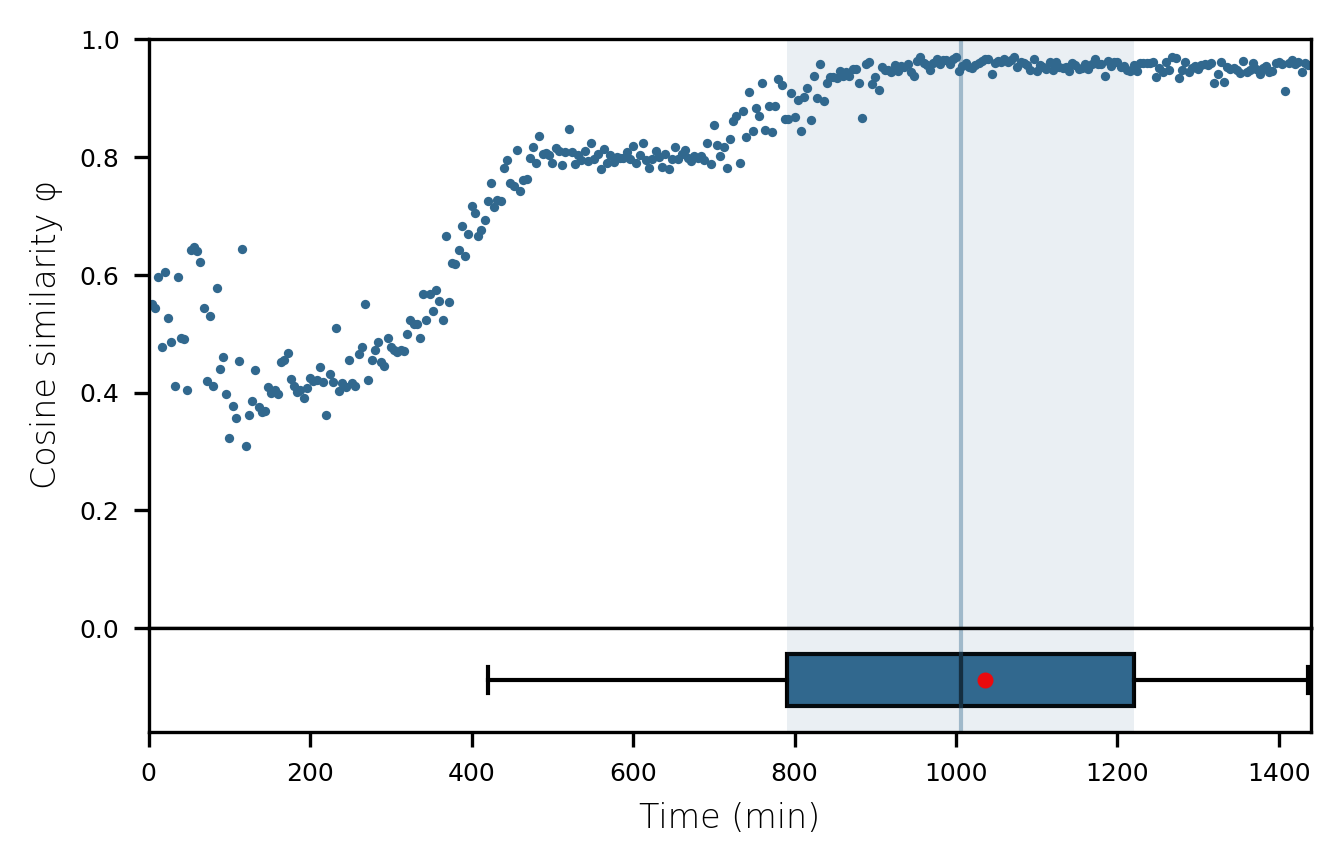

NameError: name 'np' is not defined

In [15]:
import os

index_image_test = 400
tools_plot.plot_similarity_curve(similarities_test[index_image_test],
                                 path_save=f"{path_dst}/demo_similarity_curve_index40.svg")


# save text file 
df1 = similarities_test[40]
df_mean1 = df1.mean(axis=1)

df2 = similarities_test[120]
df_mean2 = df2.mean(axis=1)

df3 = similarities_test[400]
df_mean3 = df3.mean(axis=1)


num_timepoints_reference = len(df1)
plot_xs = range(1, num_timepoints_reference + 1)

header = "Time (min), Cosine similarity_Blastula query image, Cosine similarity_Gastrula query image,  Cosine similarity_Segmentation-stage query image "
array_list = [plot_xs, df_mean1, df_mean2, df_mean3];

# Concatenate the arrays into a single 2D NumPy array
concatenated_array = np.transpose(np.vstack(array_list))
# Specify the CSV file path where you want to save the concatenated array
output_file = os.path.join('/media/hmorales/Skynet/TwinNet/extended_data/Figure1', 'Figure1_c.csv')

# Save the concatenated array as a CSV file with header
np.savetxt(output_file, concatenated_array, delimiter=",", header=header, comments='')


## Compare similarities of embryos at different acquisition timepoints <a class="anchor" id="ninth-bullet"></a>

Compare two different similarity curves at different timepoints of a test image time series with each other by subtracting the similarity values of two curves.

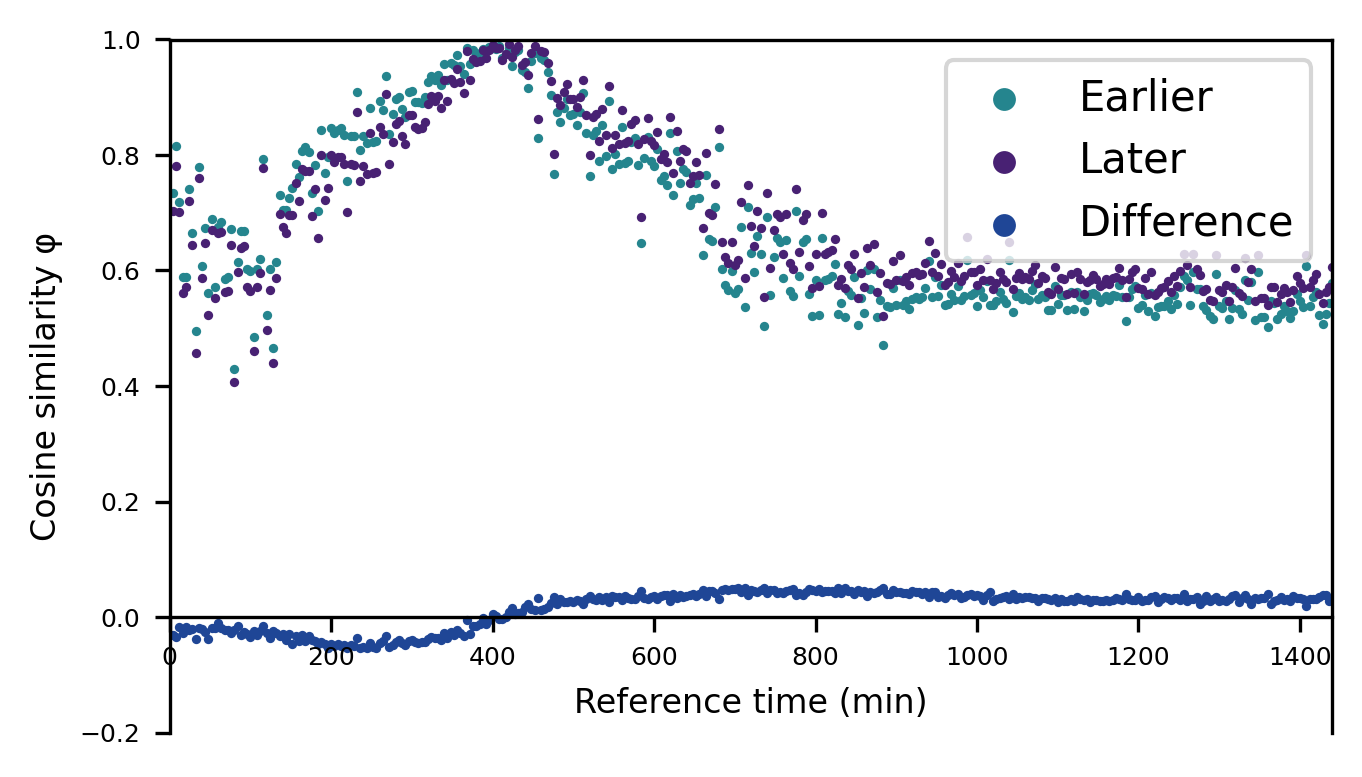

In [23]:
import numpy as np
index_image_test_earlier = 120
index_image_test_later = 121

tools_plot.plot_similarity_differences(similarities_test[index_image_test_earlier],
                                       similarities_test[index_image_test_later],
                                       path_save=f"{path_dst}/demo_similarity_differences_indices040vs140.svg")
        
df_earlier = similarities_test[index_image_test_earlier]
df_later = similarities_test[index_image_test_later]
df_earlier_mean = df_earlier.mean(axis=1)
df_later_mean = df_later.mean(axis=1)
df_diff = df_later_mean - df_earlier_mean

num_timepoints_reference = len(df_earlier_mean)
plot_atp_min_correction = 4
plot_xs = np.array(list(range(1, num_timepoints_reference + 1)))

header = "Time (min), Cosine similarity_Earlier, Cosine similarity_Later, Cosine similarity_Difference"
array_list = [plot_atp_min_correction*plot_xs, df_earlier_mean, df_later_mean, df_diff];

# Concatenate the arrays into a single 2D NumPy array
concatenated_array = np.transpose(np.vstack(array_list))
# Specify the CSV file path where you want to save the concatenated array
output_file = os.path.join('/media/hmorales/Skynet/TwinNet/extended_data/Extended-Data-Figure2', 'Extended-Data-Figure2_b.csv')

# Save the concatenated array as a CSV file with header
np.savetxt(output_file, concatenated_array, delimiter=",", header=header, comments='')

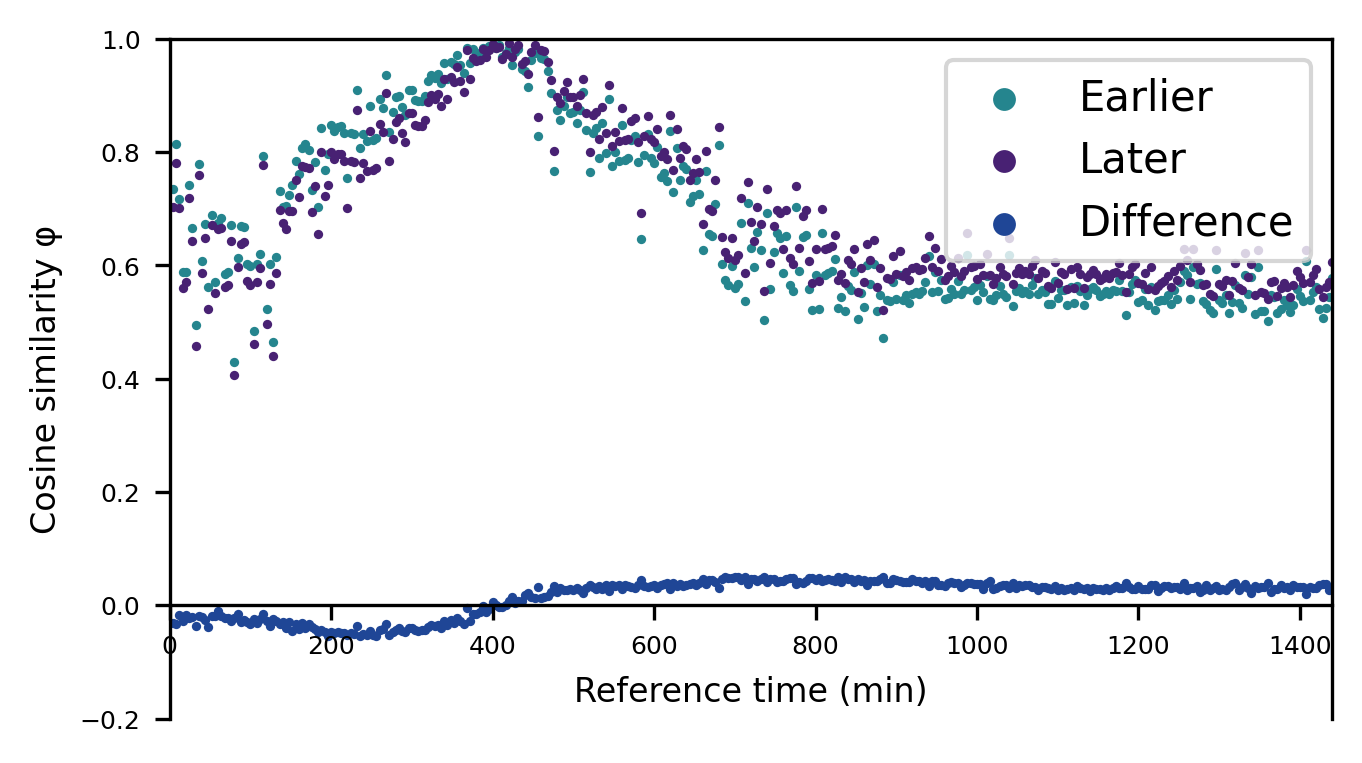

In [22]:
index_image_test_earlier = 120
index_image_test_later = 121

tools_plot.plot_similarity_differences(similarities_test[index_image_test_earlier],
                                       similarities_test[index_image_test_later],
                                       path_save=f"{path_dst}/demo_similarity_differences_indices120vs121.svg")

In [3]:
import numpy as np
bins = np.arange(11) - 0.5
print(bins)

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5]


In [4]:
nModes = 5
for i in range(1,nModes):
    F_name = f'F_{i}'
    print(F_name)

F_1
F_2
F_3
F_4


In [4]:
# Source path
import os
import pandas as pd

folder_path = '/media/hmorales/Skynet/TwinNet/extended_data/Figure3'  
# Excel file name to create
excel_file = os.path.join(folder_path,'Figure3.xlsx')

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    


# Create a Pandas ExcelWriter object
excel_writer = pd.ExcelWriter(excel_file, engine='xlsxwriter')

# Loop through the CSV files and write each one as a separate worksheet
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    df.to_excel(excel_writer, sheet_name=csv_file, index=False)
    
# Save the Excel file
excel_writer.save()

print(f'Combined {len(csv_files)} CSV files into {excel_file}')


Combined 3 CSV files into /media/hmorales/Skynet/TwinNet/extended_data/Figure3/Figure3.xlsx


/tmp/ipykernel_325731/875499928.py:24: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
